In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt # for plotting
from sklearn import metrics

# reload model
print("reload model_status")
model_status = tf.keras.models.load_model('model_status')
model_status.summary()

print("reload model_months")
model_months = tf.keras.models.load_model('model_months')
model_months.summary() # Check its architecture

reload model_status
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 52)                208       
_________________________________________________________________
dense (Dense)                (None, 52)                2756      
_________________________________________________________________
batch_normalization_1 (Batch (None, 52)                208       
_________________________________________________________________
dense_1 (Dense)              (None, 208)               11024     
_________________________________________________________________
batch_normalization_2 (Batch (None, 208)               832       
_________________________________________________________________
dense_2 (Dense)              (None, 156)               32604     
_________________________________________________________________
batch_normalization_3 (Batch (None, 

In [2]:
# Regenerate dataset
# load dataframe from .csv file
application_record = pd.read_csv("./data/details_final.csv")
application_record.drop(['Unnamed: 0', 'aid', 'ID', 'ID.1'], inplace=True, axis=1) # drop unnecessary columns
application_record.drop(['overdue_freq', 'overdue_times'], inplace=True, axis=1) # drop unnecessary columns
application_record.fillna(0, inplace=True) # fill empty cells with zero

# ['CODE_GENDER'] change label
application_record['CODE_GENDER'] = application_record['CODE_GENDER'].replace(['F', 'M'], [0, 1])

## one hot encoding
# ['NAME_INCOME_TYPE']
temp = pd.get_dummies(application_record['NAME_INCOME_TYPE'])
application_record.drop('NAME_INCOME_TYPE', inplace=True, axis = 1)
for i in range(np.shape(temp)[1]):
    pos = np.shape(application_record)[1]
    application_record.insert(pos, 'INCOME_TYPE(OH).'+str(i), temp.iloc[:,i])
                        
# ['NAME_HOUSING_TYPE']
temp = pd.get_dummies(application_record['NAME_HOUSING_TYPE'])
application_record.drop('NAME_HOUSING_TYPE', inplace=True, axis = 1)
for i in range(np.shape(temp)[1]):
    pos = np.shape(application_record)[1]
    application_record.insert(pos, 'HOUSING_TYPE(OH).'+str(i), temp.iloc[:,i])
    
# ['NAME_EDUCATION_TYPE']
temp = pd.get_dummies(application_record['NAME_EDUCATION_TYPE'])
application_record.drop('NAME_EDUCATION_TYPE', inplace=True, axis = 1)
for i in range(np.shape(temp)[1]):
    pos = np.shape(application_record)[1]
    application_record.insert(pos, 'EDUCATION_TYPE(OH).'+str(i), temp.iloc[:,i])
    
# ['NAME_FAMILY_STATUS']
temp = pd.get_dummies(application_record['NAME_FAMILY_STATUS'])
application_record.drop('NAME_FAMILY_STATUS', inplace=True, axis = 1)
for i in range(np.shape(temp)[1]):
    pos = np.shape(application_record)[1]
    application_record.insert(pos, 'FAMILY_STATUS(OH).'+str(i), temp.iloc[:,i])

# ['OCCUPATION_TYPE']
temp = pd.get_dummies(application_record['OCCUPATION_TYPE'])
application_record.drop('OCCUPATION_TYPE', inplace=True, axis = 1)
for i in range(np.shape(temp)[1]):
    pos = np.shape(application_record)[1]
    application_record.insert(pos, 'OCCUPATION_TYPE(OH).'+str(i), temp.iloc[:,i])

# ['final_months'], 0 for less than 3 months, 1 for longer than 3 months.
threshold = 12
temp = pd.get_dummies(application_record['final_months'].clip(-threshold-1)//-threshold)
application_record.drop('final_months', inplace=True, axis=1)
for i in range(np.shape(temp)[1]):
    pos = np.shape(application_record)[1]
    application_record.insert(pos, 'LABEL_MONTHS(OH).'+str(i), temp.iloc[:,i])
    
# ['final_status']
application_record['final_status'] = application_record['final_status'].replace(['1', '5', 'C'], ['0', '0', '0'])
temp = pd.get_dummies(application_record['final_status'])
application_record.drop('final_status', inplace=True, axis = 1)
for i in range(np.shape(temp)[1]):
    pos = np.shape(application_record)[1]
    application_record.insert(pos, 'LABEL_STATUS(OH).'+str(i), temp.iloc[:,i])

# split to data/ label
# as well as convert to numpy array
dim = np.shape(application_record)[1]
data = application_record.iloc[:,0:(dim-4)].to_numpy()
label_months = application_record.iloc[:,(dim-4):(dim-2)].to_numpy()
label_status = application_record.iloc[:,(dim-2):dim].to_numpy()

In [3]:
# Evaluate the model_status
loss, acc = model_status.evaluate(data, label_status)
print('Restored model_months, accuracy: {:.4f}'.format(acc))

1140/1140 [==============================] - 8s 5ms/step - loss: 0.4437 - accuracy: 0.7978
Restored model_months, accuracy: 0.7978


In [4]:
# Evaluate the model_months
loss, acc = model_months.evaluate(data, label_months)
print('Restored model_months, accuracy: {:.4f}'.format(acc))

1140/1140 [==============================] - 6s 5ms/step - loss: 0.4310 - accuracy: 0.8042
Restored model_months, accuracy: 0.8042


In [5]:
def sigmoid(x):
    y = 1/(1 + np.exp(-x))
    return y

In [10]:
def activation(y):
    """
    modded sigmoid function
    Input
    - y: (float) output of the classifier, shape 1X2
        [1, 0] => no overdue
        [0, 1] => potential overdue
    Return
    - pred: (int) prediction, scalar
        0 => potential credit card
        1 => no credit card
    - poss: (float) possibility of getting a credit card
    """
    if (y[0,0] >= y[0,1]):
        pred = 0; # give prediction
        poss = sigmoid(y[0, 0]*2);
    else:
        pred = 1; # give prediction
        poss = 1 - sigmoid(y[0, 1]*2);
    return (pred, poss)

# test code
print("Input shape:", np.shape(data[i,:].reshape(1, 52))) # input of the model must be 1X52
for i in range(50):
    status_poss = activation(model_status.predict(data[i,:].reshape(1, 52)))[1]
    months_poss = activation(model_months.predict(data[i,:].reshape(1, 52)))[1]
    poss = (status_poss + months_poss)/2 # average
    print("Overall possibility = {:.2f}".format(poss))

input shape: (1, 52)
Overall possibility = 0.12
Overall possibility = 0.12
Overall possibility = 0.44
Overall possibility = 0.16
Overall possibility = 0.16
Overall possibility = 0.16
Overall possibility = 0.16
Overall possibility = 0.13
Overall possibility = 0.13
Overall possibility = 0.13
Overall possibility = 0.50
Overall possibility = 0.51
Overall possibility = 0.51
Overall possibility = 0.51
Overall possibility = 0.51
Overall possibility = 0.51
Overall possibility = 0.51
Overall possibility = 0.50
Overall possibility = 0.50
Overall possibility = 0.12
Overall possibility = 0.12
Overall possibility = 0.12
Overall possibility = 0.50
Overall possibility = 0.50
Overall possibility = 0.51
Overall possibility = 0.51
Overall possibility = 0.51
Overall possibility = 0.51
Overall possibility = 0.51
Overall possibility = 0.51
Overall possibility = 0.51
Overall possibility = 0.51
Overall possibility = 0.54
Overall possibility = 0.54
Overall possibility = 0.54
Overall possibility = 0.54
Overall

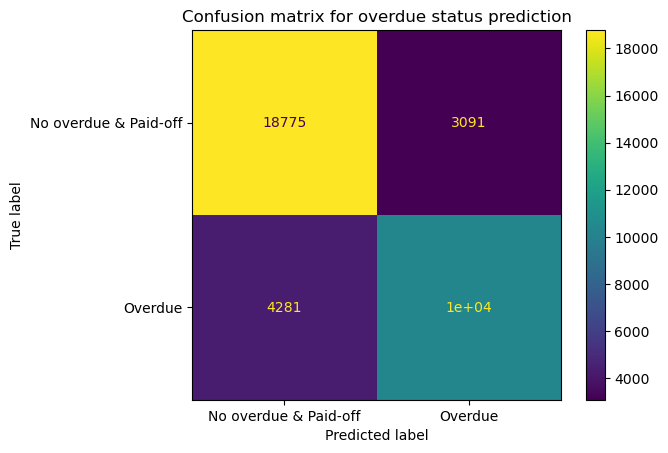

In [7]:
# Plot the confusion matrix
label_status = pd.DataFrame(label_status)
pred_status = pd.DataFrame(model_status.predict(data))
# use pandas .idxmax for reversed one hot encoding
conf_matrix = metrics.confusion_matrix(label_status.idxmax(1), pred_status.idxmax(1))
conf_matrix_plt = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["No overdue & Paid-off", "Overdue"]) # [0, 1, 2]
conf_matrix_plt.plot()
plt.title("Confusion matrix for overdue status prediction")
plt.show()

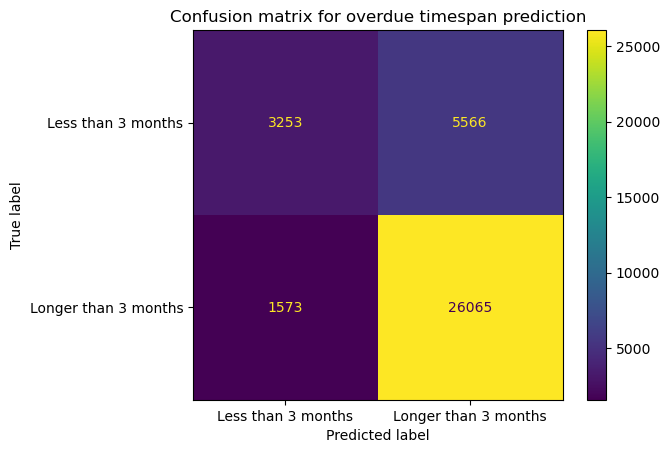

In [8]:
# Plot the confusion matrix
label_months = pd.DataFrame(label_months)
pred_months = pd.DataFrame(model_months.predict(data))
# use pandas .idxmax for reversed one hot encoding
conf_matrix = metrics.confusion_matrix(label_months.idxmax(1), pred_months.idxmax(1))
conf_matrix_plt = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["Less than 3 months", "Longer than 3 months"]) # [0, 1, 2]
conf_matrix_plt.plot()
plt.title("Confusion matrix for overdue timespan prediction")
plt.show()